# Imports

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import random


# Question 1

### i) How many rows (samples) and columns (features) are present in the dataset?

### Ans:

In [92]:
df = pd.read_csv('../data/Project1-ClassificationDataset.csv')

print(f'There are {df.shape[0]} rows (samples) in the dataset.')
print(f'There are {df.shape[1]} columns (features) in the dataset.')


There are 3476 rows (samples) in the dataset.
There are 8 columns (features) in the dataset.


### ii)  Plot 3 histograms on : 

### (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;

### (b) The column leaf_label–class on the x-axis;

### (c) The column root_label–class on the x-axis;


### Ans (a):

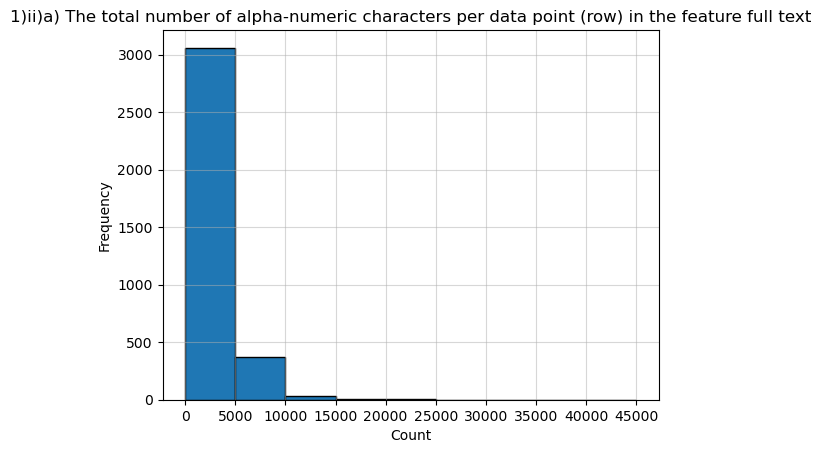

['3060', '369', '35', '8', '2', '0', '1', '0', '1']


In [93]:
alpha_numeric_characters_per_row = df['full_text'].apply(
    lambda row: sum(char.isalnum() for char in str(row))
).tolist()
counts, _, _ = plt.hist(
    alpha_numeric_characters_per_row,
    bins = np.linspace(0,45000,10,True),
    edgecolor = 'black'
)
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='x', alpha=0.5)
plt.xticks(np.linspace(0,45000,10,True))
plt.title('1)ii)a) The total number of alpha-numeric characters per data point (row) in the feature full text')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

print([f"{count:.0f}" for count in counts])


### Ans (b):

Text(0, 0.5, 'Frequency')

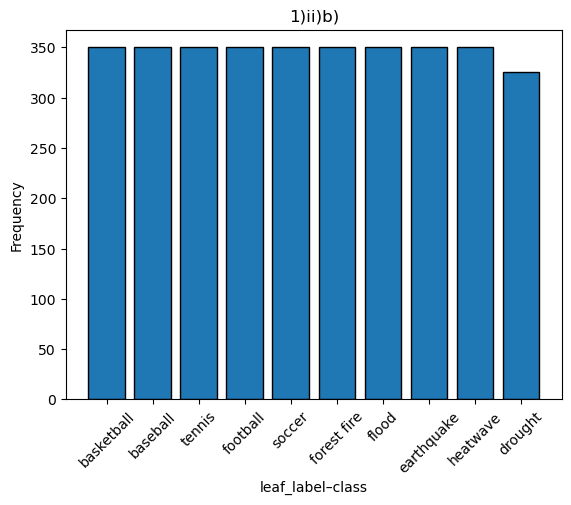

In [94]:
plt.bar(
    df['leaf_label'].value_counts().index.astype(str),
    df['leaf_label'].value_counts().values,
    edgecolor = 'black'
)
plt.title('1)ii)b)')
plt.xlabel('leaf_label–class')
plt.xticks(rotation=45)
plt.ylabel('Frequency')


### Ans (c):

Text(0, 0.5, 'Frequency')

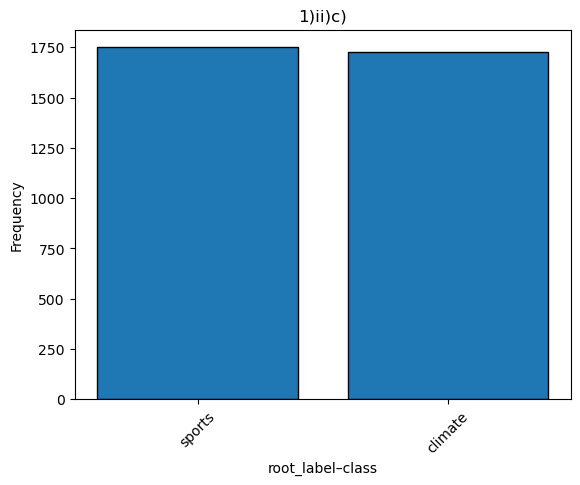

In [95]:
plt.bar(
    df['root_label'].value_counts().index.astype(str),
    df['root_label'].value_counts().values,
    edgecolor = 'black'
)
plt.title('1)ii)c)')
plt.xlabel('root_label–class')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

### iii) Provide qualitative interpretations of the histograms.

For plot (a), we can conclude that most (3060/3476*100 = 88.03%) of the data points have between 0 and 5000 alpha-numeric characters. For counts beyond 5000, there is approximately an exponential decrease in the frequency.

In plot (b), we are trying to ascertain the number of data points corresponding to each granular (or 'leaf'/low-level) label. It seems that the dataset is well-balanced between the 10 classes, which means that a model trained to classify a new data-point (as one of the 10 classes) should result in an unbiased multi-class classifier.

In plot (c), we are trying to ascertain the number of data points corresponding to each high-level (or 'root') label. Ofcourse, it follows from both the plot and our observation in plot (b), that our dataset is well-balanced between the 2 classes, which means that a model trained to classify a new data-point (as one of the 2 classes) should result in an unbiased binary classifier. 



# Question 2




In [96]:
np.random.seed(42)
random.seed(42)

In [97]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df[["full_text","root_label", "leaf_label"]], test_size=0.2, random_state = 42)

### Storing and loading dfs to ensure consistency for collaborators (they will ignore everything upto this markdown section proceed directly from read _csv below)

In [98]:
train.to_csv('../data/train_df.csv', index=False)
test.to_csv('../data/test_df.csv', index=False)

# Lorenzo and Arthur will begin loading the data from here

In [99]:
train = pd.read_csv('../data/train_df.csv')
test = pd.read_csv('../data/test_df.csv')

### Report the number of training and testing samples.

### Ans:

In [100]:
print(f'There are {train.shape[0]} training samples.')
print(f'There are {test.shape[0]} testing samples.')


There are 2780 training samples.
There are 696 testing samples.


# Question 3

### Text cleaning:

In [101]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

print(train.head())
print(test.head())

train['full_text'] = train['full_text'].apply(
    lambda row: clean(row)
)
test['full_text'] = test['full_text'].apply(
    lambda row: clean(row)
)
print(train.head())
print(test.head())

                                           full_text root_label  leaf_label
0  'While the four-day Aftershock's economic impa...    climate  earthquake
1  'CBS Essentials is created independently of th...     sports    football
2  'Moderate-to-severe drought will likely contin...    climate     drought
3  'Colleen Flood, the longtime co-owner of The F...    climate       flood
4  'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...     sports    baseball
                                           full_text root_label   leaf_label
0  'A small patch of snow on the ground in Douai,...    climate  forest fire
1  'Antonio Zago, of Brazil, puts on a jersey dur...     sports       soccer
2  'NEW YORK >> The Las Vegas Aces became the fir...     sports   basketball
3  'Christian Abraham/Hearst Connecticut Media\n\...    climate        flood
4  'The City of Watertown is currently under a wa...    climate      drought
                                           full_text root_label  leaf_label
0  'Wh

In [102]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from string import punctuation
from tqdm import tqdm
tqdm.pandas() 
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download("stopwords")

lemmatizer = WordNetLemmatizer()
vectorizer = CountVectorizer(stop_words = 'english', min_df = 3)
tfidf_transformer = TfidfTransformer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatizer_func(sentence): 
    lemmatized_sen = []
    lemma_list = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(sentence))]
    for lemma in lemma_list:
        if (not any(char in lemma for char in punctuation) and not any(char.isdigit() for char in lemma)):
            lemmatized_sen.append(lemma.lower())
    return ' '.join(lemmatized_sen)   

train['lemmatized'] = train['full_text'].progress_apply(lemmatizer_func)
test['lemmatized'] = test['full_text'].progress_apply(lemmatizer_func)

train_features = vectorizer.fit_transform(train['lemmatized'])
test_features = vectorizer.transform(test['lemmatized'])

train_tfidf = tfidf_transformer.fit_transform(train_features)
test_tfidf = tfidf_transformer.transform(test_features)

print(train_features.shape)
print(test_features.shape)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lorenzobolls/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lorenzobolls/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/lorenzobolls/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lorenzobolls/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
 30%|██▉       | 829/2780 [00:11<00:25, 75.12it/s]


KeyboardInterrupt: 

## 1. Pros and Cons of Lemmatization vs. Stemming

|                       | **Lemmatization**                                                                                                                                               | **Stemming**                                                                                                           |
|-----------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------|
| **Definition**        | Uses vocabulary and morphological analysis (including POS tags) to return the base form (lemma).<br>Examples: “better” → “good,” “mice” → “mouse.”             | Applies rule-based chops on word endings, often just truncating affixes.<br>Examples: “better” → “bett,” “mice” → “mic.” |
| **Accuracy**          | More accurate, preserves valid lemmas and actual language usage (requires computational resources).                                                              | Less accurate, can produce stems that aren’t real words or meaningful forms.                                            |
| **Complexity**        | Slower, more resource-intensive (involves POS tagging and morphological analysis).                                                                               | Faster, less resource-intensive.                                                                                            |
| **Impact on Vocabulary Size** | Can more precisely merge morphological variants into a single lemma, often reducing vocabulary size in a more controlled manner.                                                            | Also reduces vocabulary size, but less controlled. Can merge words incorrectly or generate multiple meaningless stems.   |

<br>

## 2. What is `min_df`? How Does Varying It Affect the TF-IDF Matrix?

### Definition of Document Frequency

Let:
- $ \mathcal{D} $ = the set of all documents, with $\lvert \mathcal{D} \rvert = N$.
- $t$ = a term in the vocabulary.

We define the **document frequency** of \(t\) as:

$$
\text{df}(t) \;=\; \bigl|\{\, d \in \mathcal{D} : t \in d \}\bigr|.
$$

In other words, $\text{df}(t)$ is the count of how many documents in $\mathcal{D}$ contain the term $t$.

### Applying `min_df`

**`min_df`** = the **minimum document frequency** threshold. 
 - If we choose $min\_df = 5$, then only terms $t$ with $\text{df}(t) \ge 5$ will be included in our vocabulary.
 - Formally, the **reduced vocabulary** $V_{min\_df}$ is:
   $$
   V_{min\_df} = \{\, t : \text{df}(t) \ge min\_df \}.
   $$
 - **Effect**: Increasing `min_df` removes more terms (especially rare ones), thus **reducing the number of columns** in the TF-IDF matrix. Decreasing `min_df` adds more terms, **increasing dimensionality**.

**Train**: $(\text{num_train_samples}, |V_{min_df}|)$  
**Test**: $(\text{num_test_samples}, |V_{min_df}|)$



<br>

## 3. Should I Remove Stopwords, Punctuation, and Numbers Before or After Lemmatizing?

- **Stopwords**  
  Ideally, we want the lemmatizer to see all words in context (which can sometimes help with POS tagging), hence, we remove them **after** lemmatization to maintain fidelity.

- **Punctuation**  
  We should remove punctuation **after** lemmatization as this helps in the case of handling contractions such as "can't" or "won't". If we removed the punctuations before lemmatization, the lemmatizer would see words like "cant" or "wont" and wouldn't be able to lemmatize these words correctly.

- **Numbers**  
  It is best to remove them **after** lemmatization because numbers can signal plural forms or help disambiguate part-of-speech. For example, “He addresses 2 addresses” is a sentence where the word "addresses" can be both a verb and a plural noun. Therefore, removing numbers in such cases too soon can lead to ambiguous tagging.

<br>

## 4. Reporting TF-IDF Shapes

Finally, after transforming your text data into TF-IDF features:

- **Train matrix shape**:  
  $
    (\text{2780}, \;\text{12516})
  $
- **Test matrix shape**:  
  $
    (\text{696}, \;\text{12516})
  $

where $\text{12516} \approx k \times 10^3 \quad \text{with} \quad k \approx 12.5$.

# Question 4

### (i) Plot the explained variance ratio across multiple different k = [1,5,10,25,50,100,500,1000] for LSI and for the next few sections choose k = 25. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?

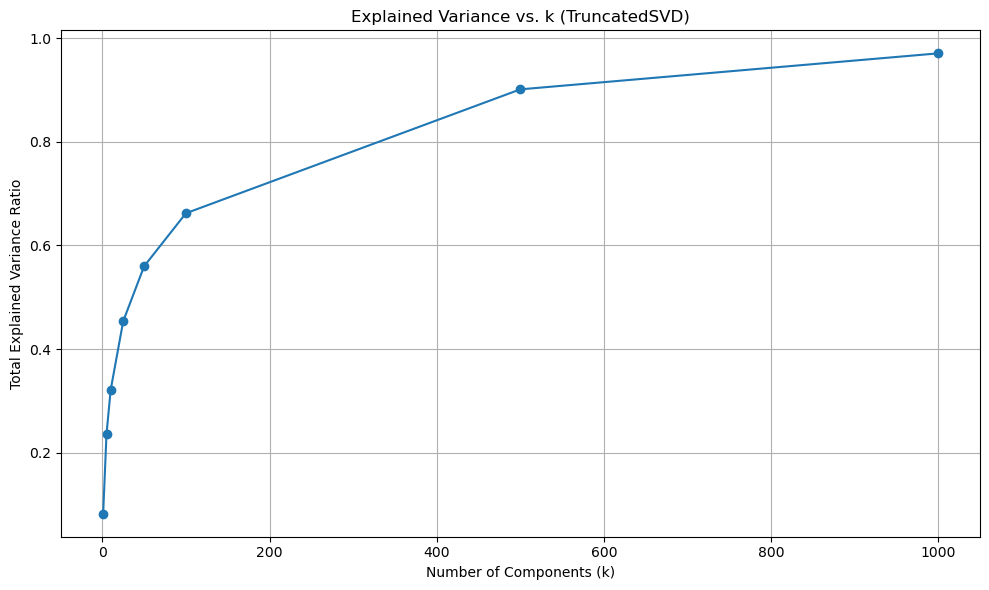

In [ ]:
from sklearn.decomposition import TruncatedSVD

k_values = [1, 5, 10, 25, 50, 100, 500, 1000]
explained_variances = []
for k in k_values:
    svd_k = TruncatedSVD(n_components=k, random_state=42)
    svd_k.fit(train_features)
    explained_variances.append(np.sum(svd_k.explained_variance_ratio_))

plt.figure(figsize=(10,6))
plt.plot(k_values, explained_variances, marker='o')
plt.title("Explained Variance vs. k (TruncatedSVD)")
plt.xlabel("Number of Components (k)")
plt.ylabel("Total Explained Variance Ratio")
plt.grid(True)
plt.tight_layout() 
plt.show()


## Explained Variance Ratio Plot

The plot of "explained variance ratio" vs. `k` **increases quickly** at lower `k` and **starts to flatten** as `k` grows. This **concavity** indicates **diminishing returns**: after a certain point, adding more dimensions yields only marginal increases in explained variance.



### (ii) With k = 25 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF– they both should use the same k = 25. Which one is larger, the $\|X - W H\|_F^2$ in NMF or the $\|X - U_k \Sigma_k V_k^T\|_F^2$ in LSI and why?

In [ ]:
from sklearn.decomposition import NMF
from sklearn.utils.extmath import randomized_svd

k = 25
U_tr, S_tr, V_tr = randomized_svd(train_features, n_components=k, random_state=42)
train_LSI_recon = U_tr @ np.diag(S_tr) @ V_tr
LSI_train_error = np.sum(np.array(train_features - train_LSI_recon)**2)

U_te, S_te, V_te = randomized_svd(test_features, n_components=k, random_state=42)
test_LSI_recon = U_te @ np.diag(S_te) @ V_te
LSI_test_error = np.sum(np.array(test_features - test_LSI_recon)**2)


nmf_25 = NMF(n_components=k, init='random', random_state=42)
W_tr = nmf_25.fit_transform(train_features)   
H = nmf_25.components_                        
train_NMF_recon = W_tr @ H
NMF_train_error = np.sum(np.array(train_features - train_NMF_recon)**2)

W_te = nmf_25.transform(test_features)       
test_NMF_recon = W_te @ H
NMF_test_error = np.sum(np.array(test_features - test_NMF_recon)**2)

print("=== LSI ===")
print(f"Train MSE Error: {LSI_train_error:.4f}")
print(f"Test  MSE Error: {LSI_test_error:.4f}")

print("\n=== NMF ===")
print(f"Train MSE Error: {NMF_train_error:.4f}")
print(f"Test  MSE Error: {NMF_test_error:.4f}")





=== LSI ===
Train MSE Error: 1659270.7944
Test  MSE Error: 387545.1724

=== NMF ===
Train MSE Error: 1694297.4418
Test  MSE Error: 572994.9551


### **Comparing Errors** (LSI vs. NMF)

- **LSI (Truncated SVD)**  
  1. **Optimal low-rank approximation**:  
     By design, SVD finds the best possible rank-$k$ representation of a matrix $X$ under the Frobenius norm. Mathematically, the truncated SVD solution minimizes  
     $$
     \|X - U_k \Sigma_k V_k^T\|_F^2,
     $$
     which guarantees that, among all rank-$k$ matrices, $U_k \Sigma_k V_k^T$ is the one that yields the **lowest reconstruction error** in the least-squares sense.
  2. **Negative/positive values**:  
     Because standard SVD imposes **no sign constraints**, the resulting components can include **negative and positive values**. This is typically **not** a problem if your goal is purely to reduce dimensionality and you don’t require interpretability of components.

- **NMF (Non-negative Matrix Factorization)**  
  1. **Non-negativity constraint**:  
     NMF factorizes $X$ into two non-negative matrices $W$ and $H$ so that  
     $$
     X \approx W \times H,
     $$
     with all entries in $W$ and $H$ $\geq 0$. The constraint that every entry must be non-negative is **highly restrictive**, which generally means:
     $$
     \|X - W H\|_F^2
     $$
     is often **larger** for a given rank $k$ than the unconstrained SVD’s error.
  2. **Interpretability benefit**:  
     Because the factors $W$ and $H$ are non-negative, it is easier to interpret them—particularly in topic modeling or part-based representations. For instance, in text analysis, each dimension can be viewed as a **topic** (column of $H$) composed of non-negative word weights, and each row of $W$ shows how strongly a document associates with each topic. This **interpretability** is often valuable enough to trade off some additional reconstruction error.

#### Summary
- **LSI** usually yields **lower** reconstruction error because it’s an **unconstrained** (optimal) rank-$k$ approximation.  
- **NMF** usually yields a **larger** reconstruction error for the same $k$ but can be far more **interpretable**, as it restricts the solution space to **non-negative** factors that align well with many real-world data interpretations (e.g., additive parts in images, topics in text). 


# Question 9

### We will use this cell for evaluating classification models by calculating metrics and visualizing performance through confusion matrix heatmaps

In [ ]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,  accuracy_score, precision_score, recall_score, f1_score


map_row_to_class = {
   0: "basketball", 1: "baseball", 2: "tennis",
   3: "football", 4: "soccer", 5: "forest fire",
   6: "flood", 7: "earthquake", 8: "drought", 9: "heatwave"
}


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train['leaf_label'])
y_test = label_encoder.transform(test['leaf_label'])


def print_metrics(y_true, y_pred, model_name):
   acc = accuracy_score(y_true, y_pred)
   recall = recall_score(y_true, y_pred, average='weighted')
   precision = precision_score(y_true, y_pred, average='weighted')
   f1 = f1_score(y_true, y_pred, average='weighted')
   print(f"{model_name} - Accuracy: {acc:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")

def plot_confusion_matrix(cm, model_name, class_labels):
   plt.figure(figsize=(10, 8))
   sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
   plt.title(f"Confusion Matrix for {model_name}")
   plt.xlabel("Predicted Labels")
   plt.ylabel("True Labels")
   plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB


# training naive bayes
nb_model = MultinomialNB()
nb_model.fit(train_tfidf, y_train)


nb_predictions = nb_model.predict(test_tfidf)


# making confusion matrix
conf_matrix_nb = confusion_matrix(y_test, nb_predictions)


# reorder confusion matrix to match map_row_to_class
class_order = [label_encoder.transform([map_row_to_class[i]])[0] for i in range(10)]
conf_matrix_nb_reordered = conf_matrix_nb[np.ix_(class_order, class_order)]


print_metrics(y_test, nb_predictions, "Naive Bayes")
plot_confusion_matrix(conf_matrix_nb_reordered, "Naive Bayes", list(map_row_to_class.values()))

ValueError: y contains previously unseen labels: 'forest fire'

SVM One-vs-One - Accuracy: 0.7557, Recall: 0.7557, Precision: 0.7766, F1 Score: 0.7654


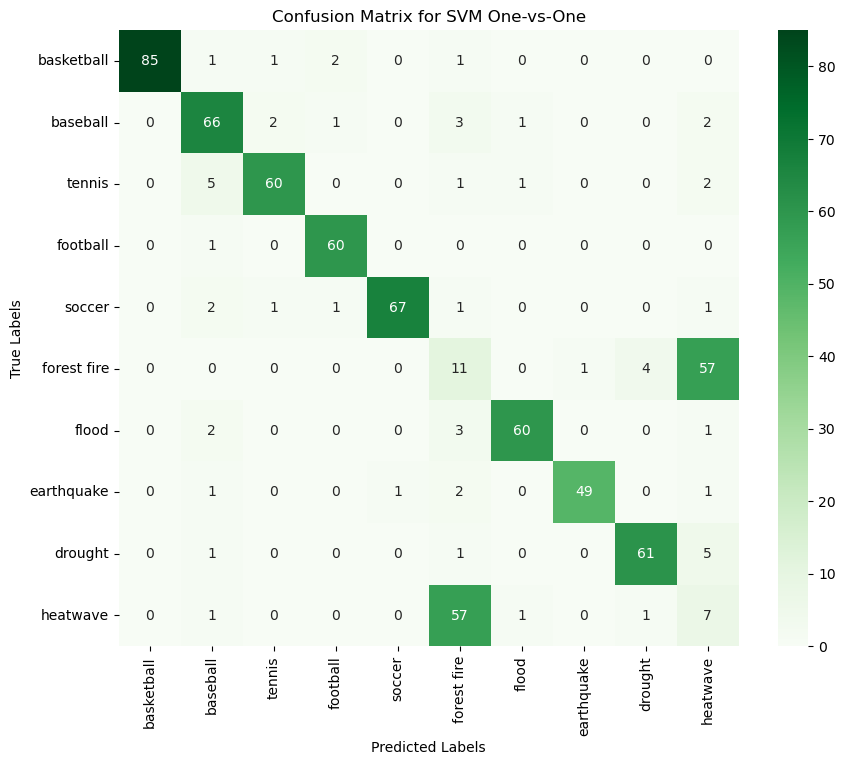

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC


# SVM One-vs-One Classifier
ovo_svm = OneVsOneClassifier(SVC(kernel='linear', class_weight='balanced', probability=True))
ovo_svm.fit(train_tfidf, y_train)


ovo_predictions = ovo_svm.predict(test_tfidf)


conf_matrix_ovo = confusion_matrix(y_test, ovo_predictions)


class_order = [label_encoder.transform([map_row_to_class[i]])[0] for i in range(10)]
conf_matrix_ovo_reordered = conf_matrix_ovo[np.ix_(class_order, class_order)]


print_metrics(y_test, ovo_predictions, "SVM One-vs-One")
plot_confusion_matrix(conf_matrix_ovo_reordered, "SVM One-vs-One", list(map_row_to_class.values()))

SVM One-vs-Rest - Accuracy: 0.7730, Recall: 0.7730, Precision: 0.7865, F1 Score: 0.7793


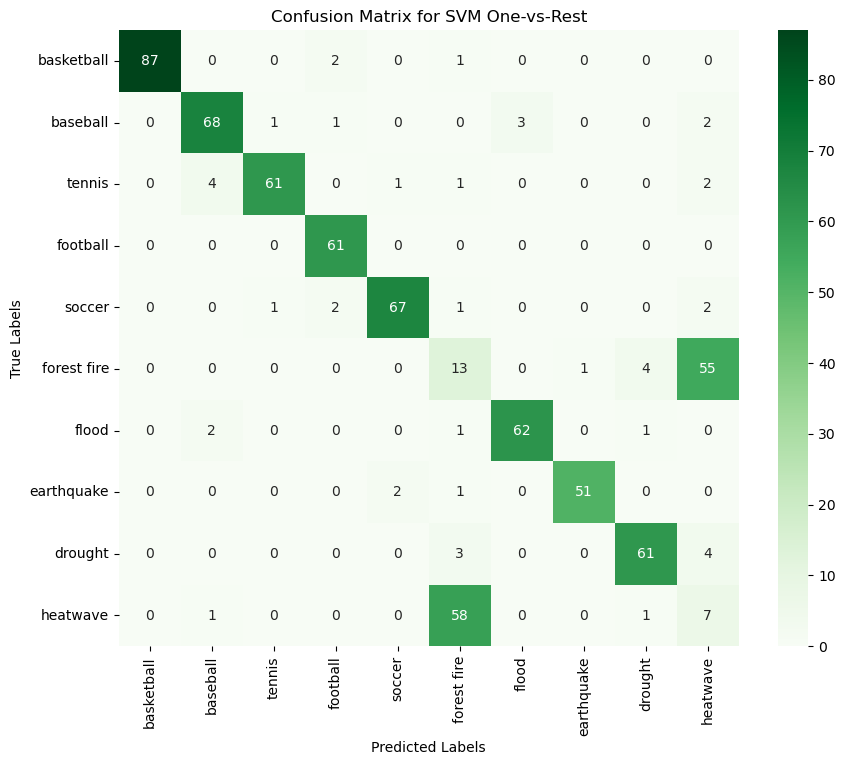

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


# Train SVM One-vs-Rest Classifier
ovr_svm = OneVsRestClassifier(SVC(kernel='linear', class_weight='balanced', probability=True))
ovr_svm.fit(train_tfidf, y_train)


ovr_predictions = ovr_svm.predict(test_tfidf)


conf_matrix_ovr = confusion_matrix(y_test, ovr_predictions)


class_order = [label_encoder.transform([map_row_to_class[i]])[0] for i in range(10)]
conf_matrix_ovr_reordered = conf_matrix_ovr[np.ix_(class_order, class_order)]


print_metrics(y_test, ovr_predictions, "SVM One-vs-Rest")
plot_confusion_matrix(conf_matrix_ovr_reordered, "SVM One-vs-Rest", list(map_row_to_class.values()))

## How did you resolve the class imbalance issue in the One VS the rest model?

We deal with the class imbalance issue by using the parameter ```class_weight='balanced'``` in the SVM. Doing so adjusts the weights of each class automatically based on their frequency, giving more important to minority classes, which ensures the model is not biased towards the majority class and learns to classify all classes more effectively.

## Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?


For the most part are distinct visible blocks along the confusion matrix's major diagonal of the confusion matrix, which indicates that the classifier is effectively distinguishing between the different classes and has a relatively high accuracy overall. However, the two noticeable off-diagonal blocks between heatwave and forest fire show that there are frequent misclassifications between tese two classes. There may be overlapping features or similarities in the data that causes the classifier to differentiate between them.


## Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix.

We will merge ```forest fire``` and ```heatwave``` into a larger label called ```fire hazard```.

Naive Bayes (Merged) - Accuracy: 0.7830, Recall: 0.7830, Precision: 0.8481, F1 Score: 0.7881


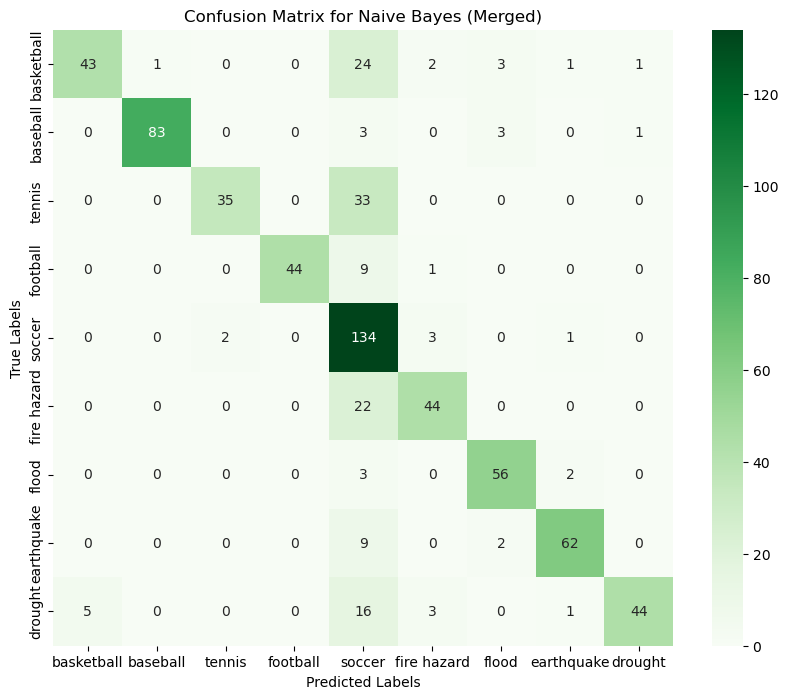

In [ ]:
map_row_to_class_merged = {
   0: "basketball", 1: "baseball", 2: "tennis", 3: "football", 4: "soccer",
   5: "fire hazard", 6: "flood", 7: "earthquake", 8: "drought"
}

# copying original datasets to prevent it messing up previous code
train_merged = train.copy()
test_merged = test.copy()

# replace "forest fire" and "heatwave" with "fire hazard" in the copies
merge = {'forest fire': 'fire hazard', 'heatwave': 'fire hazard'}
train_merged['leaf_label'] = train_merged['leaf_label'].replace(merge)
test_merged['leaf_label'] = test_merged['leaf_label'].replace(merge)

# refit the label encoder with the updated labels
label_encoder = LabelEncoder()
y_train_merged = label_encoder.fit_transform(train_merged['leaf_label'])
y_test_merged = label_encoder.transform(test_merged['leaf_label'])

# retraining with new merge labels
nb_model = MultinomialNB()
nb_model.fit(train_tfidf, y_train_merged)
nb_predictions_merged = nb_model.predict(test_tfidf)
conf_matrix_nb_merged = confusion_matrix(y_test_merged, nb_predictions_merged)

class_order_merged = list(range(len(label_encoder.classes_)))
conf_matrix_nb_reordered_merged = conf_matrix_nb_merged[np.ix_(class_order_merged, class_order_merged)]
merged_labels = list(map_row_to_class_merged.values())

# Print metrics and plot confusion matrix
print_metrics(y_test_merged, nb_predictions_merged, "Naive Bayes (Merged)")
plot_confusion_matrix(conf_matrix_nb_reordered_merged, "Naive Bayes (Merged)", merged_labels)


In [ ]:
# SVM One-vs-One Classifier with Merged Labels
ovo_svm_merged = OneVsOneClassifier(SVC(kernel='linear', class_weight='balanced', probability=True))
ovo_svm_merged.fit(train_tfidf, y_train_merged)  

# Now using merged labels for creating confusion matrix
ovo_predictions_merged = ovo_svm_merged.predict(test_tfidf)
conf_matrix_ovo_merged = confusion_matrix(y_test_merged, ovo_predictions_merged)

class_order_merged = list(range(len(label_encoder.classes_)))
conf_matrix_ovo_reordered_merged = conf_matrix_ovo_merged[np.ix_(class_order_merged, class_order_merged)]

merged_labels = list(map_row_to_class_merged.values())


In [ ]:
# Train SVM One-vs-Rest Classifier for Merged Labels
ovr_svm_merged = OneVsRestClassifier(SVC(kernel='linear', class_weight='balanced', probability=True))

# using merged labels for training and creating confusion matrix
ovr_svm_merged.fit(train_tfidf, y_train_merged) 

ovr_predictions_merged = ovr_svm_merged.predict(test_tfidf)

conf_matrix_ovr_merged = confusion_matrix(y_test_merged, ovr_predictions_merged)

# reordering the merged labels for confusion matrix
class_order_merged = list(range(len(label_encoder.classes_))) 
conf_matrix_ovr_reordered_merged = conf_matrix_ovr_merged[np.ix_(class_order_merged, class_order_merged)]


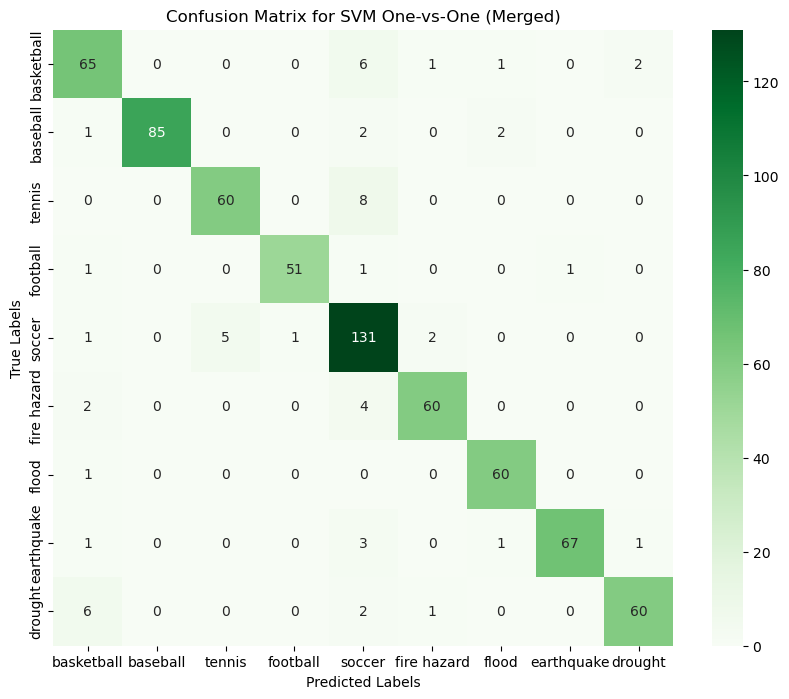

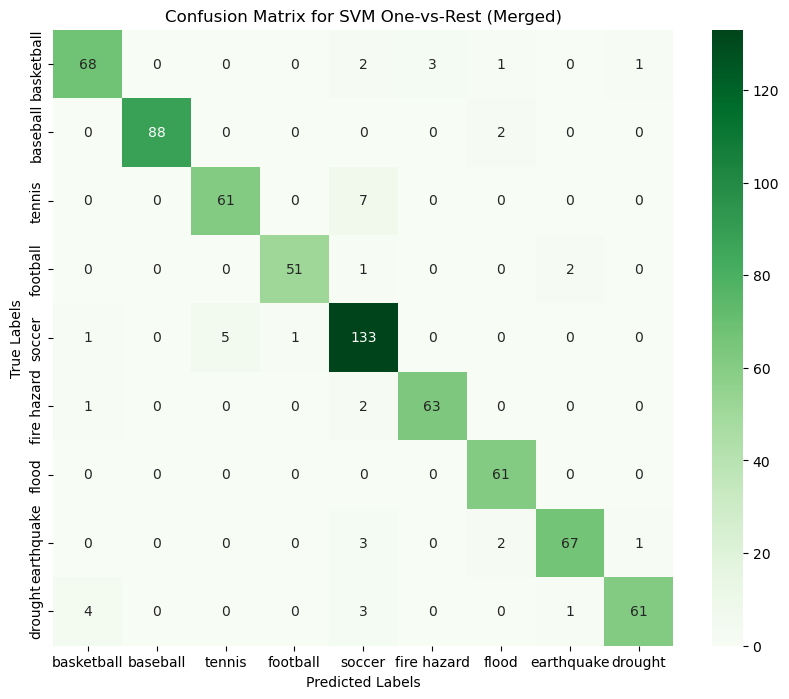

SVM One-vs-One (Merged) - Accuracy: 0.9181, Recall: 0.9181, Precision: 0.9221, F1 Score: 0.9189
SVM One-vs-Rest (Merged) - Accuracy: 0.9382, Recall: 0.9382, Precision: 0.9398, F1 Score: 0.9383


In [ ]:
# plot both confusion matrices
plot_confusion_matrix(conf_matrix_ovo_reordered_merged, "SVM One-vs-One (Merged)", merged_labels)

merged_labels = list(map_row_to_class_merged.values())
plot_confusion_matrix(conf_matrix_ovr_reordered_merged, "SVM One-vs-Rest (Merged)", merged_labels)

# print metrics for both SVM One-vs-One and One-vs-Rest
print_metrics(y_test_merged, ovo_predictions_merged, "SVM One-vs-One (Merged)")
print_metrics(y_test_merged, ovr_predictions_merged, "SVM One-vs-Rest (Merged)")


## How did the accuracy change in One VS One and One VS the rest?

One VS One saw a 16.24% improvement while One VS Rest saw a 16.52% improvement.

## Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest.

In [ ]:
from imblearn.over_sampling import SMOTE

# resample the merged training dataset to balance classes
smote = SMOTE(random_state=42)
X_train_merged_balanced, y_train_merged_balanced = smote.fit_resample(train_tfidf, y_train_merged)


In [ ]:
# Train the One-vs-One classifier with balanced merged data
ovo_svm_balanced = OneVsOneClassifier(SVC(kernel='linear', class_weight='balanced', probability=True))
ovo_svm_balanced.fit(X_train_merged_balanced, y_train_merged_balanced)

ovo_predictions_balanced = ovo_svm_balanced.predict(test_tfidf)
conf_matrix_ovo_balanced = confusion_matrix(y_test_merged, ovo_predictions_balanced)

class_order_merged = list(range(len(label_encoder.classes_)))
conf_matrix_ovo_reordered_balanced = conf_matrix_ovo_balanced[np.ix_(class_order_merged, class_order_merged)]


In [ ]:
# Train the One-vs-Rest classifier with balanced merged data
ovr_svm_balanced = OneVsRestClassifier(SVC(kernel='linear', class_weight='balanced', probability=True))
ovr_svm_balanced.fit(X_train_merged_balanced, y_train_merged_balanced)

ovr_predictions_balanced = ovr_svm_balanced.predict(test_tfidf)
conf_matrix_ovr_balanced = confusion_matrix(y_test_merged, ovr_predictions_balanced)

class_order_merged = list(range(len(label_encoder.classes_)))
conf_matrix_ovr_reordered_balanced = conf_matrix_ovr_balanced[np.ix_(class_order_merged, class_order_merged)]

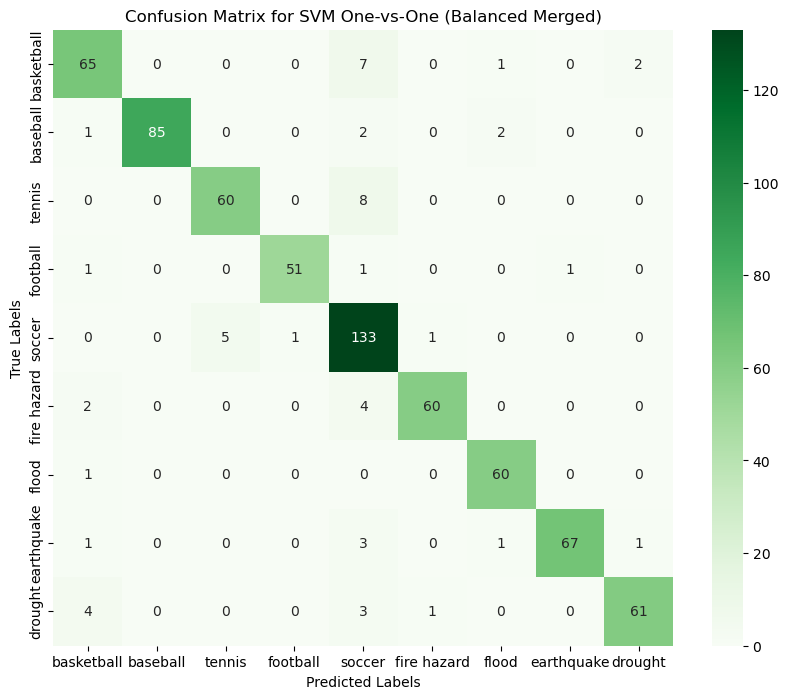

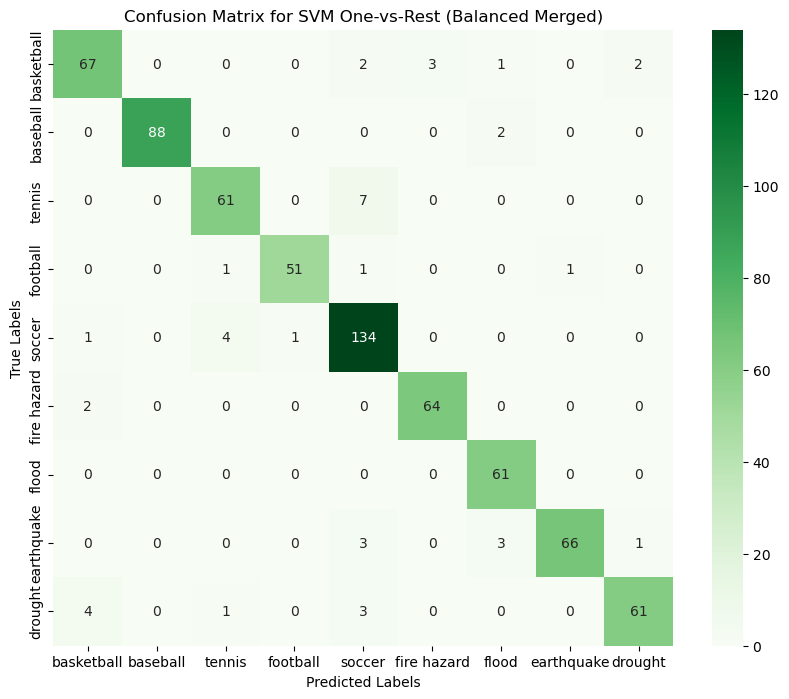

SVM One-vs-One (Balanced Merged) - Accuracy: 0.9224, Recall: 0.9224, Precision: 0.9269, F1 Score: 0.9232
SVM One-vs-Rest (Balanced Merged) - Accuracy: 0.9382, Recall: 0.9382, Precision: 0.9398, F1 Score: 0.9382


In [ ]:
plot_confusion_matrix(conf_matrix_ovo_reordered_balanced, "SVM One-vs-One (Balanced Merged)", list(map_row_to_class_merged.values()))
plot_confusion_matrix(conf_matrix_ovr_reordered_balanced, "SVM One-vs-Rest (Balanced Merged)", list(map_row_to_class_merged.values()))

print_metrics(y_test_merged, ovo_predictions_balanced, "SVM One-vs-One (Balanced Merged)")
print_metrics(y_test_merged, ovr_predictions_balanced, "SVM One-vs-Rest (Balanced Merged)")

## Does class imbalance impact the performance of the classification once some classes are merged?

Class imbalance negatively impacts the One-vs-One classifcation when some classes are merged. We can see this from the Accuracy increasing from 91.81% to 92.24% when we balance the dataset. However, class imbalance doesn't impact the One-vs-Rest classification and the accuracy remains the same at 93.82%.